# Using Elasticsearch for reading and query data from json format

# Table of Contents

0. Setup Elastic Stack Services
1. Install Dependencies
2. Connect to Elasticsearch
3. Data Import
4. Create a Pandas DataFrame
5. Elasticsearch Settings and Mappings
6. Format Data for Elasticsearch
7. Create Elasticsearch Index
8. Import Data into Elasticsearch
9. Query Elasticsearch
10. More Complicated Query
11. Import data through Logstash
12. Visualize data through Kibana

### 0. Start Elastic Stack Services

In [ ]:
# Elastic Search service
!cd elasticsearch-8.10.4
!cd bin
elasticsearch

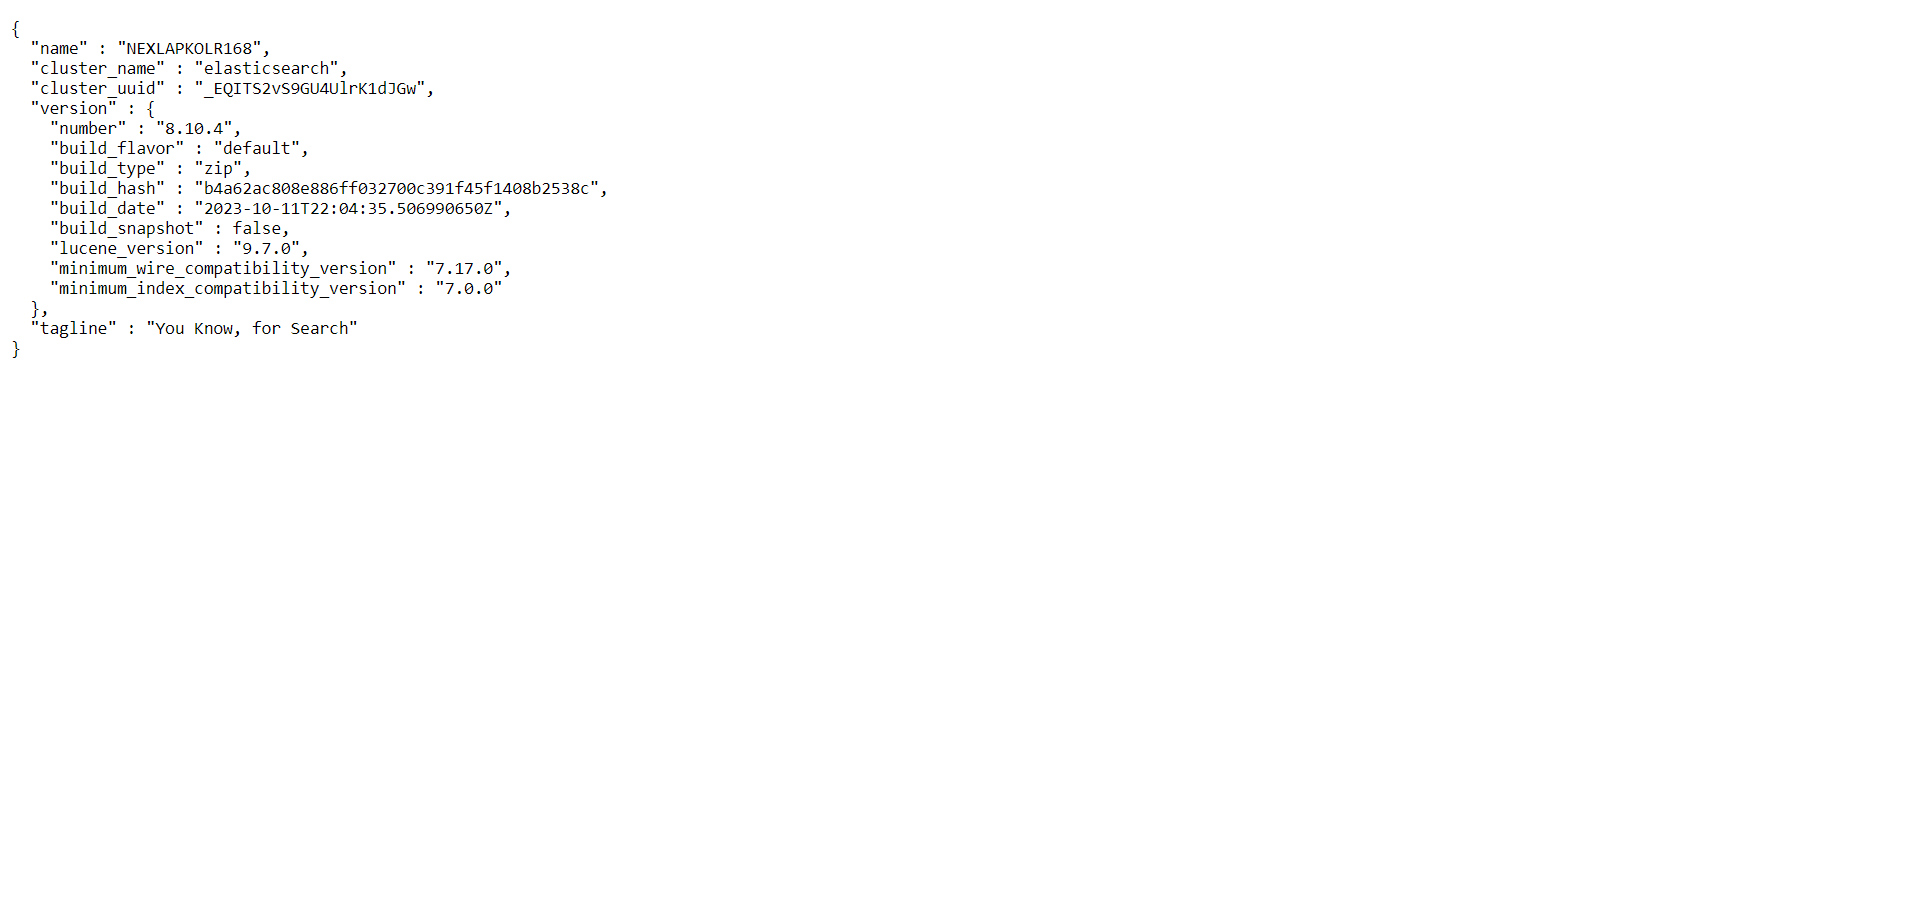

In [ ]:
# Kibana service
!cd kibana-8.10.4
!cd bin
kibana.bat

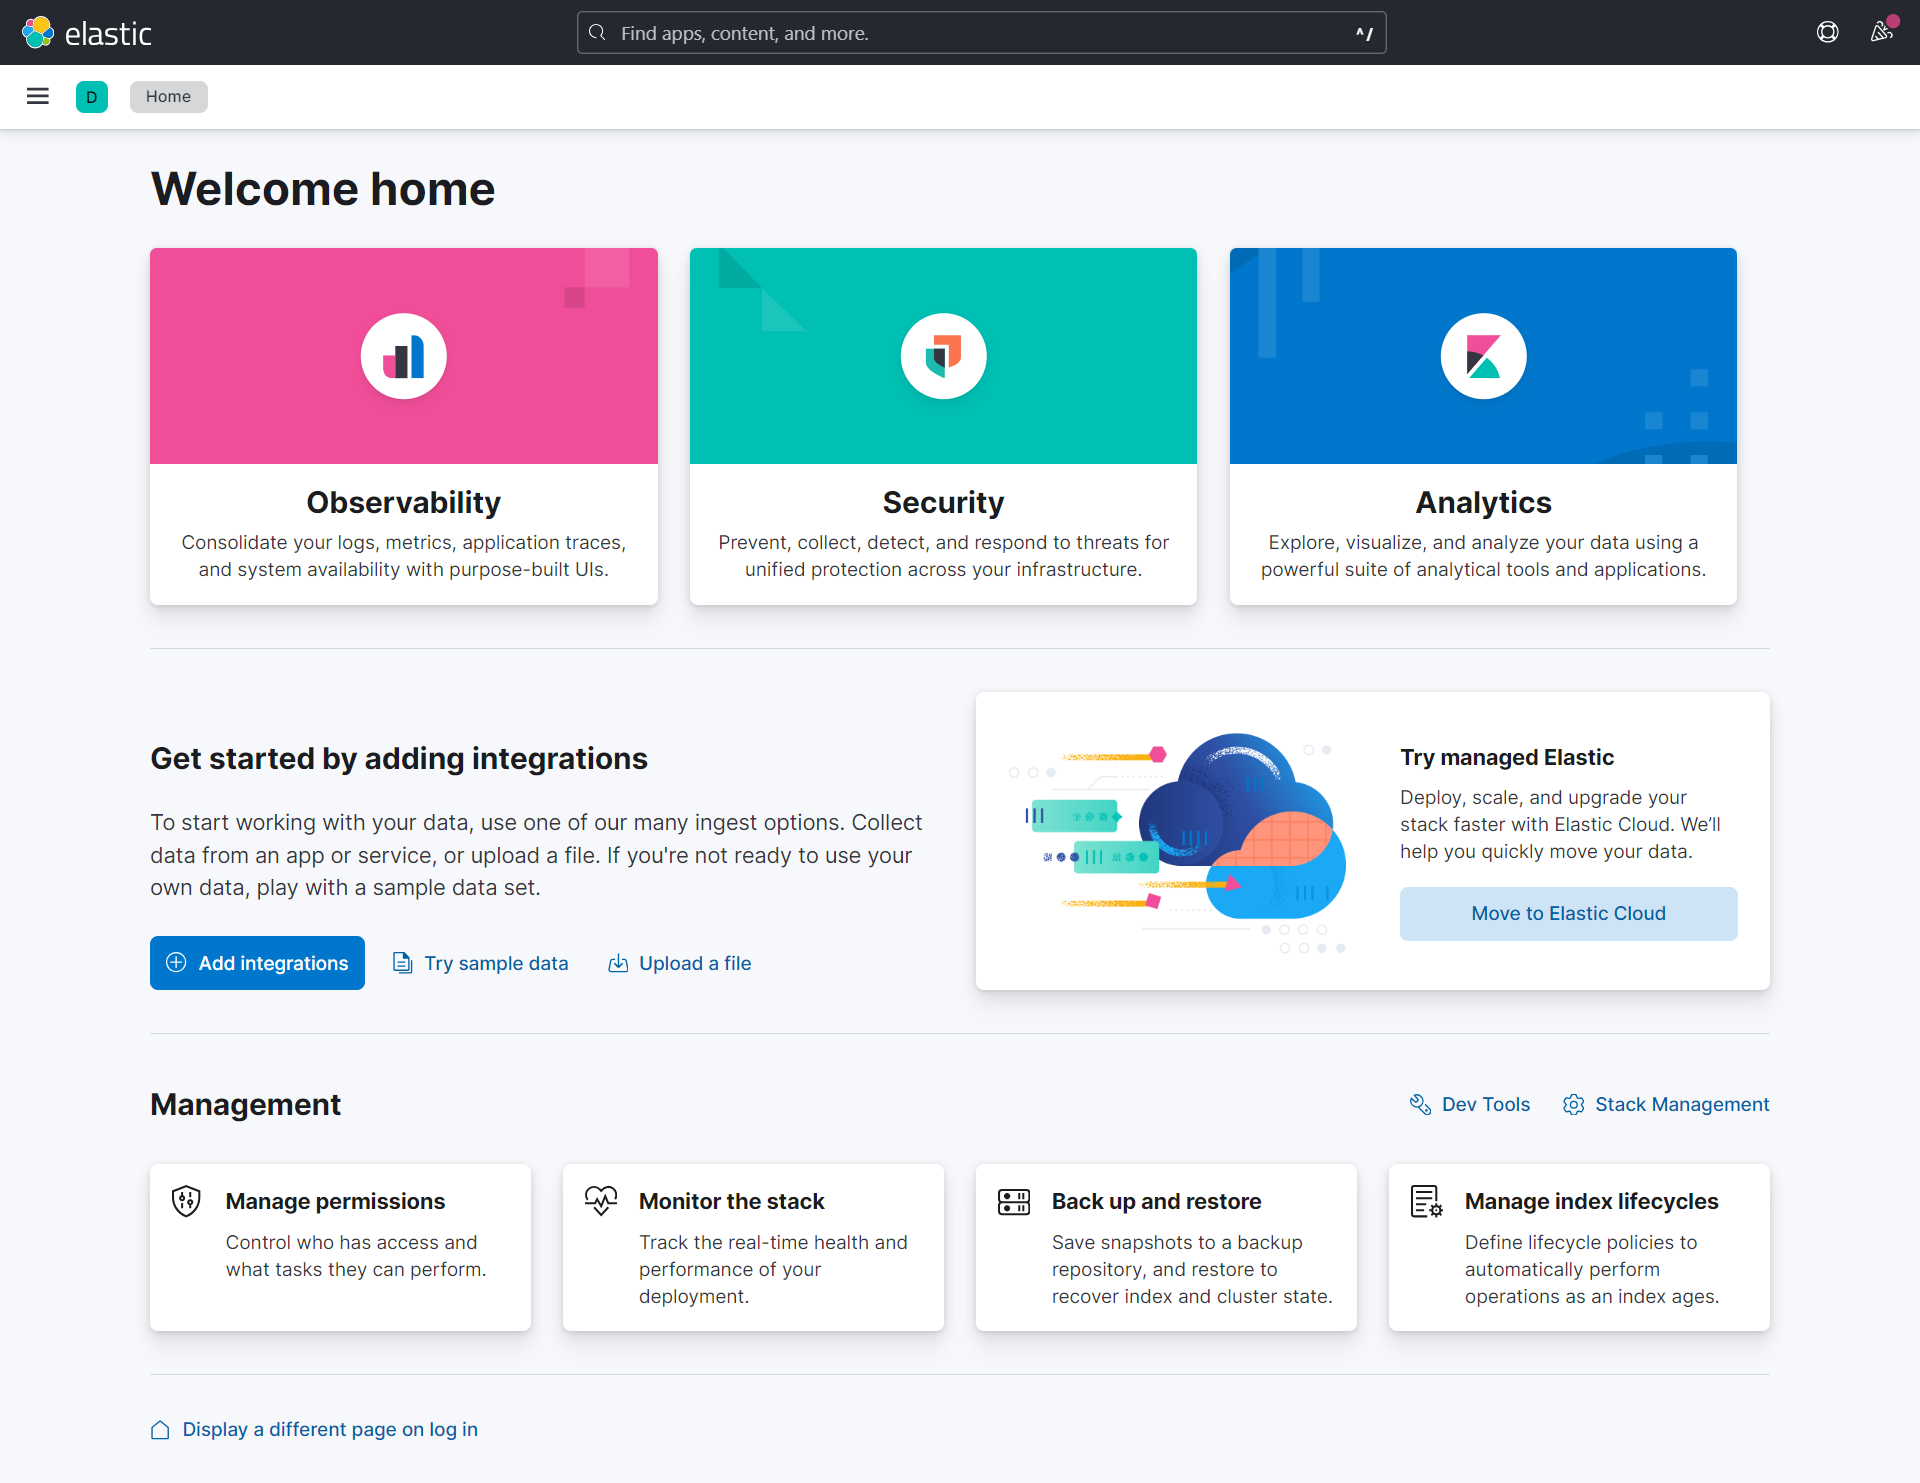

### 1. Install Dependencies

In [ ]:
!pip install elasticsearch

In [23]:
import elasticsearch
from elasticsearch import Elasticsearch
from elasticsearch import helpers
from elasticsearch.helpers import bulk
import json
import pandas as pd

### 2. Connect to Elasticsearch

In [40]:
es = Elasticsearch(hosts = [{"host":"localhost", "port":9200, "scheme":"http"}])

# Check if python is connected to elasticsearch
es.ping()

True

### 3. Data Import

In [41]:
# Read data from the JSON file
data = []
with open('labelled_crime_reports.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

### 4. Create a Pandas DataFrame

In [42]:
# Convert to DataFrame
df = pd.DataFrame(data)
df.head()

,id,text,meta,annotation_approver,labels
0,2311,Officers were dispatched to a robbery of the A...,{},None,"[[30, 38, Crime], [45, 92, Address], [233, 248..."
1,2312,The MPD was called to Pink at West Towne Mall ...,{},None,"[[22, 45, Address], [46, 59, Crime_datetime], ..."
2,2313,"The MPD is seeking help locating a unique $1,5...",{},None,"[[66, 72, Crime], [91, 105, Address], [114, 13..."
3,2314,A Radcliffe Drive resident said three men - at...,{},None,"[[2, 17, Address], [79, 87, Weapon], [112, 130..."
4,2315,An 86-year-old woman contacted the MPD after p...,{},None,"[[460, 473, Crime], [821, 837, Reporting_offic..."


In [43]:
df = pd.DataFrame(columns=['text'])

In [44]:
# Iterate through the data and extract labeled information
for item in data:
    labels = item['labels']
    text = item['text']
    
    # Create a dictionary to store extracted labels and values
    extracted_info = {'text': text}
    
    for label in labels:
        start, end, column_name = label
        extracted_info[column_name] = text[start:end]
    
    # Append the extracted information to the DataFrame
    df = df.append(extracted_info, ignore_index=True)

In [45]:
print(f"shape of dataset: {df.shape}")
df.head()

shape of dataset: (189, 8)


,text,Address,Crime,Reported_date,Reported_time,Reporting_officer,Weapon,Crime_datetime
0,Officers were dispatched to a robbery of the A...,Associated Bank in the 1500 block of W Broadway,a demanded mone,d 08/09/20,t 6:17,y Sgt. Jennifer Ka,. No weap,NaN
1,The MPD was called to Pink at West Towne Mall ...,Pink at West Towne Mall,thefts,08/18/2016,10:37,PIO Joel Despain,NaN,Tuesday night
2,"The MPD is seeking help locating a unique $1,5...",Union St. home,stolen,08/17/2016,11:09 AM,PIO Joel Despain,NaN,that night
3,A Radcliffe Drive resident said three men - at...,Radcliffe Drive,targeted armed robbery,08/07/2018,11:17 AM,PIO Joel Despain,handguns,early this morning
4,An 86-year-old woman contacted the MPD after p...,NaN,fraud attempt,03/27/2019,10:28 AM,PIO Joel Despain,NaN,NaN


### 5. Elasticsearch Settings and Mappings

In [46]:
# Define settings & mappings of Elasticsearch index
Settings = {
    "settings":{
        "number_of_shards":1,
        "number_of_replicas":0
    },
    "mappings":{
        "properties":{
            "title":{
                "type":"text"
            },
            "abstract":{
                "type":"text"
            }
        }
    }
}

### 6. Format Data for Elasticsearch

In [47]:
def json_formatter(dataframe, index_name, index_type='_doc'):
    """
    This function is used to create JSON formatted dictionaries for Elasticsearch.

    Args:
      dataframe: The DataFrame to be converted to JSON.
      index_name: Name of the Elasticsearch index.
      index_type: Type of the Elasticsearch index (default: '_doc').
    Returns:
      A list of JSON-formatted dictionaries.
    """
    try:
        json_data = []
        for _, row in dataframe.iterrows():
            doc = {
                '_index': index_name,
                #'_type': index_type,  # Include the type if needed (for Elasticsearch 6.x and earlier)
                '_source': row.to_dict()  # Convert the row to a dictionary
            }
            json_data.append(doc)
        return json_data
    except Exception as e:
        print("Error during JSON formatting: {}".format(e))
        return None

### 7. Create Elasticsearch Index

In [48]:
# Check if the index 'crime_index' already exists
if not es.indices.exists(index="analysis_index"):
    # If it doesn't exist, create it with the specified settings and mappings
    MY_INDEX = es.indices.create(index="analysis_index", ignore=[400, 404], body=Settings)
    print(f"Index 'analysis_index' created.")
else:
    # If it exists, consolidate or update the settings and mappings as needed
    es.indices.put_mapping(index="analysis_index", body=Settings["mappings"])
    print(f"Index 'analysis_index' already exists, consolidated settings and mappings.")

C:\Users\aviparna.biswas\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  after removing the cwd from sys.path.


Index 'analysis_index' created.


In [58]:
json_Formatted_dataset = json_formatter(dataframe=df, index_name='analysis_index')
json_Formatted_dataset[0]

{'_index': 'analysis_index',
 '_source': {'text': 'Officers were dispatched to a robbery of the Associated Bank in the 1500 block of W Broadway. A M/W described as 5\'04" â€“ 5\'05" and 130 lbs., wearing a gray hooded sweatshirt, dark sunglasses, and a blue bandana around his mouth area demanded money from a teller. No weapon was mentioned or displayed. A K-9 track was attempted. The track ended at a nearby apartment complex. Released 08/09/2018 at 6:17 PM by Sgt. Jennifer Kane',
  'Address': 'Associated Bank in the 1500 block of W Broadway',
  'Crime': 'a demanded mone',
  'Reported_date': 'd 08/09/20',
  'Reported_time': 't 6:17 ',
  'Reporting_officer': 'y Sgt. Jennifer Ka',
  'Weapon': '. No weap',
  'Crime_datetime': nan}}

### 8. Import Data into Elasticsearch

In [59]:
# Dictionary to store unique document IDs
unique_source_text = set()

In [60]:
# List to store documents to index
documents_to_index = []

In [61]:
# Iterate through the JSON documents and check for duplicates based on source text
for document in json_Formatted_dataset:
    source_text = document['_source']['text']
    
    if source_text not in unique_source_text:
        # If it's not a duplicate, add it to the list of documents to index
        unique_source_text.add(source_text)
        documents_to_index.append(document)

In [62]:
#For importing Data to elasticsearch we use elasticsearch's bulk API from elasticsearch.helpers
try:
    res = helpers.bulk(es, json_Formatted_dataset)
    print("Successfully imported data to Elasticsearch.")
except Exception as e:
    print(f"Error: {e}")

Error: 157 document(s) failed to index.


### 9. Query Elasticsearch

In [63]:
# Get 10 sample of data
query = es.search(
    index="analysis_index",
    body={
      "size":10,
      "query": {
        "match_all":{}
      }
    }
)

output = pd.json_normalize((query['hits']['hits']))
output

,_index,_id,_score,_ignored,_source.text,_source.Address,_source.Crime,_source.Reported_date,_source.Reported_time,_source.Reporting_officer,_source.Weapon,_source.Crime_datetime
0,analysis_index,GFGaqYsBNv736286h86N,1.0,[text.keyword],A Radcliffe Drive resident said three men - at...,Radcliffe Drive,targeted armed robbery,08/07/2018,11:17 AM,PIO Joel Despain,handguns,early this morning
1,analysis_index,G1GaqYsBNv736286h86N,1.0,[text.keyword],A convenience store clerk was robbed at gunpoi...,south on Todd Dr.,robbed at gunpoint,12/14/2017,9:28 AM,PIO Joel Despain,weapon,before 11:00 p.m
2,analysis_index,H1GaqYsBNv736286h86N,1.0,[text.keyword],"""It's the scariest thing in my whole life,"" an...","State St., near the Capitol Square",stabbing,09/11/2017,8:58 AM,PIO Joel Despain,knife,early this morning
3,analysis_index,IFGaqYsBNv736286h86N,1.0,[text.keyword],A group of children are believed responsible f...,"Falk Elementary School, 6323 Woodington Way",shattered glass,06/19/2017,12:24 PM,PIO Joel Despain,brick,Saturday afternoon
4,analysis_index,IVGaqYsBNv736286h86N,1.0,[text.keyword],Madison Police Responded to the 3000 Block of ...,3000 Block of Darbo Drive,stab,11/25/2016,2:25 PM,Sgt. Nicholas Ellis,broken glass,12:30PM
5,analysis_index,JlGaqYsBNv736286h86N,1.0,[text.keyword],"A 13-year-old boy, who pointed a handgun at a ...",1500 block of Troy,disorderly conduct while armed,10/12/2016,10:11 AM,PIO Joel Despain,BB or pellet gun,last night
6,analysis_index,KFGaqYsBNv736286h86N,1.0,[text.keyword],A Madison mother was driving with her 18-year-...,East Washington Ave.,road rage incident,06/11/2019,9:10 AM,PIO Joel Despain,handgun,Monday morning
7,analysis_index,OVGaqYsBNv736286h86N,1.0,[text.keyword],A concerned caller told police a driver fired ...,"Center for Limnology, 680 N. Park St.",weapon's violation,07/06/2018,10:55 AM,PIO Joel Despain,flare gun,3:00 a.m.
8,analysis_index,PVGaqYsBNv736286h86N,1.0,[text.keyword],A crime victim and his neighbor - who came out...,McKee Rd.,theft,06/30/2016,1:01 PM,PIO Joel Despain,handgun,4:20 a.m.
9,analysis_index,QFGaqYsBNv736286h86N,1.0,[text.keyword],"On June 11, 2019 at approximately 11:09pm, Mad...",E. Gilman and E. Gorham Street,pistol whipped,06/12/2019,1:15 AM,Sgt. Nathan Becker,firearm,"June 11, 2019 at approximately 11:09pm"


### 10. More Complicated Query

In [64]:
# More complicated query
query = es.search( 
    index="analysis_index",
    body={
        "size":20,
        "query":{
            "bool":{
                "must":[
                        {"multi_match":{
                            "query":"officer despain handled cases",
                            "fields":["text","address","crime","reported_time"]
                        }}
                ]
            }
        }
    }
)

output = pd.json_normalize((query['hits']['hits']))
output

,_index,_id,_score,_ignored,_source.text,_source.Address,_source.Crime,_source.Reported_date,_source.Reported_time,_source.Reporting_officer,_source.Weapon,_source.Crime_datetime
0,analysis_index,PVGaqYsBNv736286h86N,2.426172,[text.keyword],A crime victim and his neighbor - who came out...,McKee Rd.,theft,06/30/2016,1:01 PM,PIO Joel Despain,handgun,4:20 a.m.
1,analysis_index,YFGaqYsBNv736286h86N,1.935944,[text.keyword],"A knife-wielding man, who threatened a couple ...",downtown,screaming at others,11/12/2018,10:02 AM,PIO Joel Despain,knife,Sunday afternoon
2,analysis_index,OVGaqYsBNv736286h86N,1.891937,[text.keyword],A concerned caller told police a driver fired ...,"Center for Limnology, 680 N. Park St.",weapon's violation,07/06/2018,10:55 AM,PIO Joel Despain,flare gun,3:00 a.m.
3,analysis_index,xlGaqYsBNv736286h86O,1.891937,[text.keyword],A concerned caller told police a driver fired ...,"the Center for Limnology, 680 N. Park",ht's weapon's viol,Released,06/2018,0:55 AM by PIO J,h a flare,"e Fourth of July, around 11:00 p."
4,analysis_index,KFGaqYsBNv736286h86N,1.787826,[text.keyword],A Madison mother was driving with her 18-year-...,East Washington Ave.,road rage incident,06/11/2019,9:10 AM,PIO Joel Despain,handgun,Monday morning
5,analysis_index,H1GaqYsBNv736286h86N,1.701061,[text.keyword],"""It's the scariest thing in my whole life,"" an...","State St., near the Capitol Square",stabbing,09/11/2017,8:58 AM,PIO Joel Despain,knife,early this morning
6,analysis_index,TlGaqYsBNv736286h86N,0.336446,[text.keyword],A Fordem Avenue resident reported his assault ...,Fordem Avenue,burglary,04/15/2019,11:02 AM,PIO Joel Despain,assault rifle,Friday afternoon
7,analysis_index,W1GaqYsBNv736286h86N,0.336446,NaN,"A burglar broke a window at U.S. Bank, 6401 Co...","U.S. Bank, 6401 Cottage Grove Rd.",stolen,09/12/2016,12:37 PM,PIO Joel Despain,pry tool,early Saturday morning
8,analysis_index,r1GaqYsBNv736286h86O,0.330148,[text.keyword],The MPD is investigating a bank robbery over t...,"Old National Bank, 302 N. Midvale Blvd.",bank robbery,02/02/2018,1:20 PM,PIO Joel Despain,handgun,just before 12:30 p.m.
9,analysis_index,GFGaqYsBNv736286h86N,0.318234,[text.keyword],A Radcliffe Drive resident said three men - at...,Radcliffe Drive,targeted armed robbery,08/07/2018,11:17 AM,PIO Joel Despain,handguns,early this morning


### 11. Import Data through Logstash

In [68]:
!logstash -f logstash.conf #Change directory for your logstash.conf file

"Using bundled JDK: D:\elastic_stack\logstash-8.10.4\jdk\bin\java.exe"
Sending Logstash logs to D:/elastic_stack/logstash-8.10.4/logs which is now configured via log4j2.properties
[2023-11-07T21:19:50,753][INFO ][logstash.runner          ] Log4j configuration path used is: D:\elastic_stack\logstash-8.10.4\config\log4j2.properties
[2023-11-07T21:19:50,756][INFO ][logstash.runner          ] Starting Logstash {"logstash.version"=>"8.10.4", "jruby.version"=>"jruby 9.4.2.0 (3.1.0) 2023-03-08 90d2913fda OpenJDK 64-Bit Server VM 17.0.8+7 on 17.0.8+7 +indy +jit [x86_64-mswin32]"}
[2023-11-07T21:19:50,758][INFO ][logstash.runner          ] JVM bootstrap flags: [-Xms1g, -Xmx1g, -Djava.awt.headless=true, -Dfile.encoding=UTF-8, -Djruby.compile.invokedynamic=true, -XX:+HeapDumpOnOutOfMemoryError, -Djava.security.egd=file:/dev/urandom, -Dlog4j2.isThreadContextMapInheritable=true, -Djruby.regexp.interruptible=true, -Djdk.io.File.enableADS=true, --add-exports=jdk.compiler/com.sun.tools.javac.api=ALL-U

### 12. Visualize data in Kibana

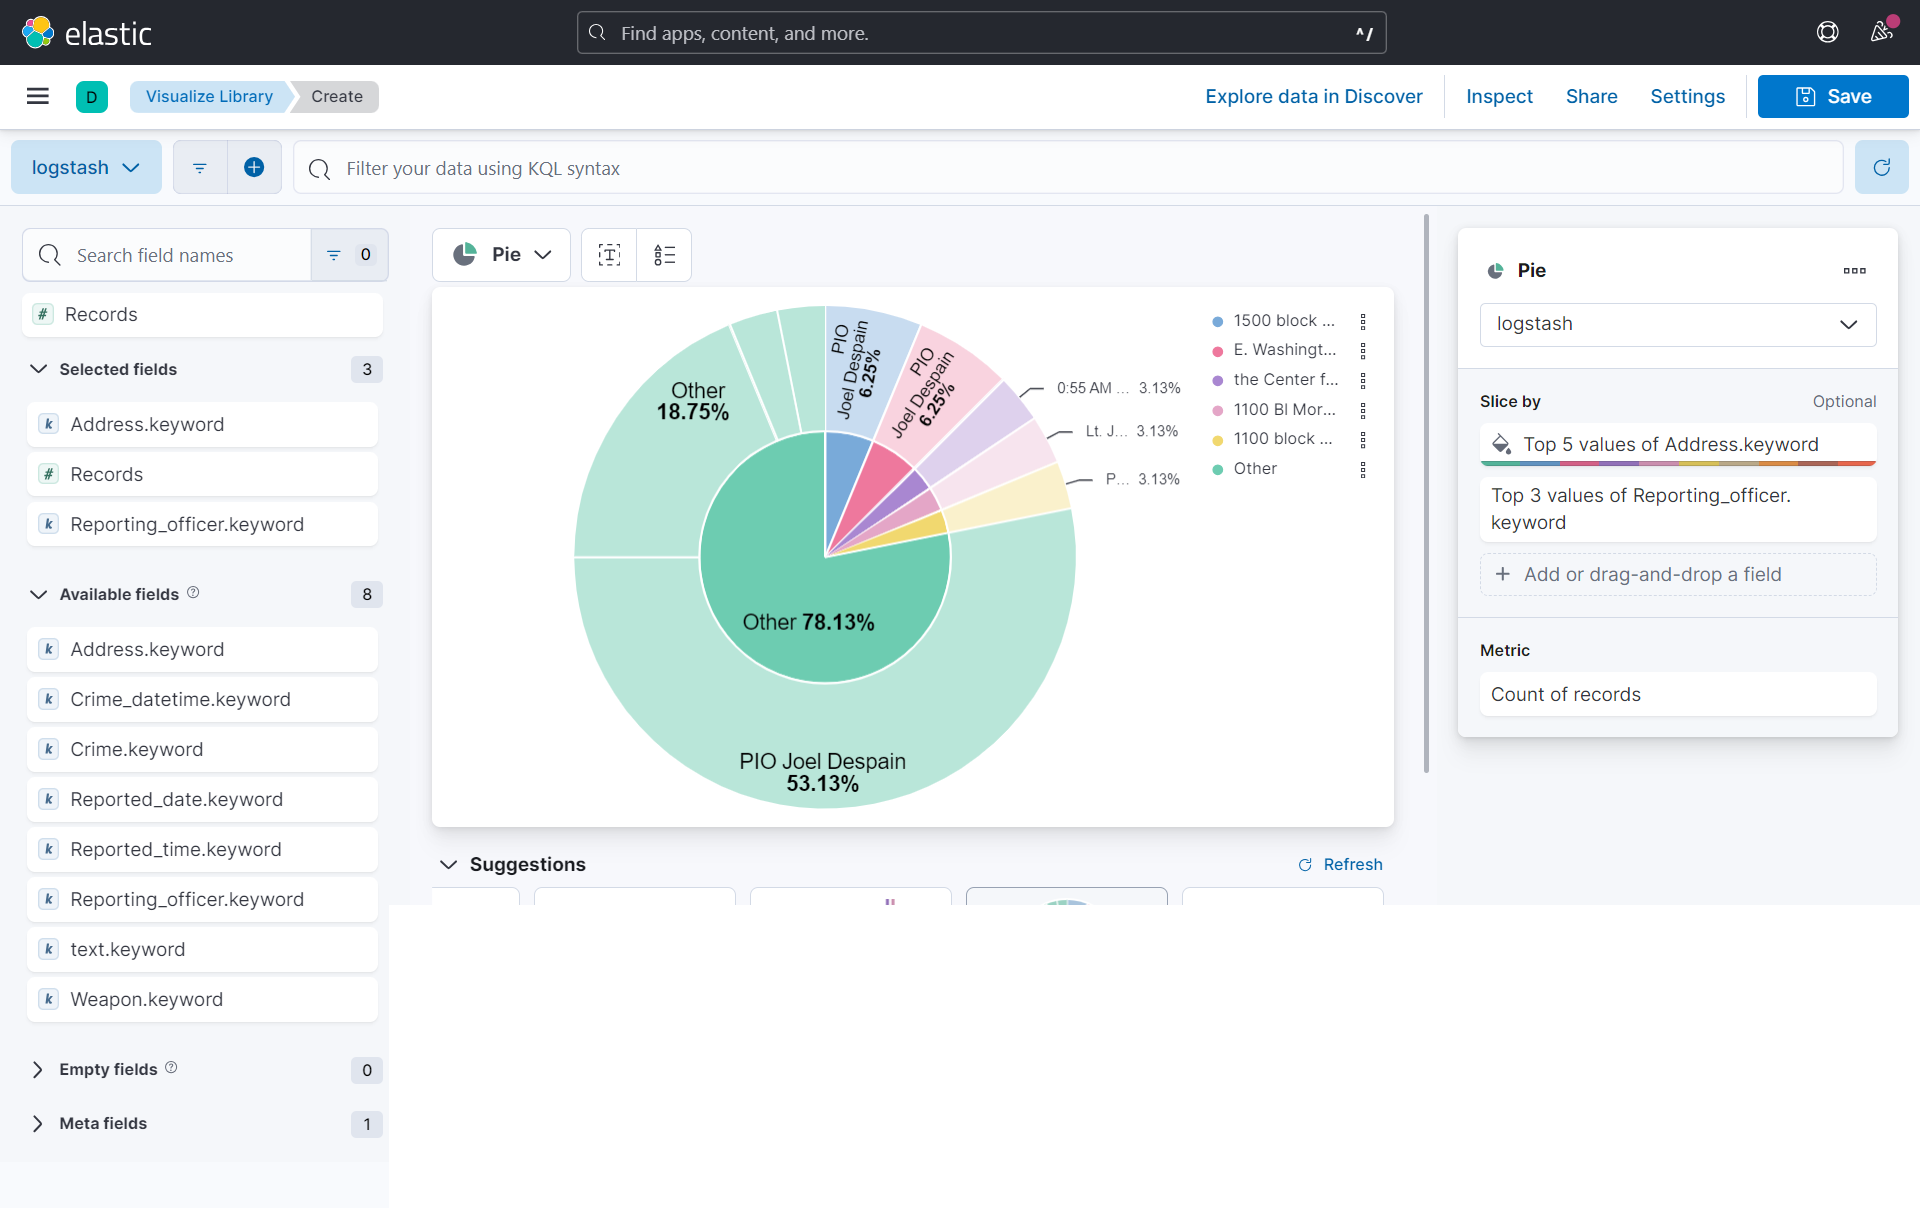